In [1]:
import pangolin as pg
import numpy as np

Based loosely on [this example](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html) from the skikitlearn
documentation.

In [13]:
# generate training data
ndata = 20
sigma = 0.05 # true noise level
#x_obs = np.random.rand(ndata)*10
x_obs = [0.5, 1, 1.5, 1.75, 2.1, 3.5, 4.7, 5.0, 5.1, 5.2, 5.45, 8.7, 8.8, 8.9, 9.1, 9.2, 9.5, 9.7,
         9.8, 10.0]
print(len(x_obs))
y_obs = x_obs * np.sin(x_obs) + sigma * np.random.randn(ndata)

# combine training and "test" data
x_test = np.arange(0,10,.1)
x = np.concatenate([x_obs,x_test])

20


In [14]:
# kernel function
def kernel(x):
    N = len(x)
    K = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            K[i,j] = np.exp(-1*(x[i]-x[j])**2)
    # make PSD
    return .5*(K+K.T) + .1*np.eye(N)

# compute kernel
K = kernel(x)

# define model
z = pg.multi_normal(np.zeros(len(x)),K)
y_train = pg.vmap(pg.normal,(0,None))(z[:ndata],sigma)
y_test = pg.vmap(pg.normal,(0,None))(z[ndata:],sigma)

# do inference
[ys] = pg.inference.numpyro.sample_flat([y_test], [y_train], [y_obs])

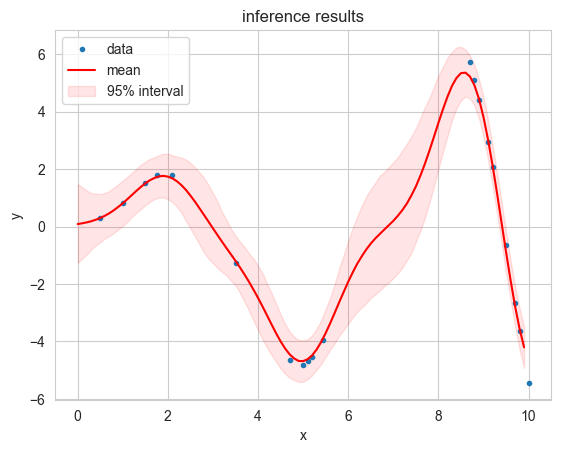

In [15]:
# plot
from matplotlib import pyplot as plt
y_pred = np.mean(ys,axis=0)
y_lo = np.quantile(ys,.025,axis=0)
y_hi = np.quantile(ys,.975,axis=0)

plt.plot(x_obs,y_obs,'.',label='data')
plt.plot(x_test,y_pred,'r-',label='mean')
plt.fill_between(x_test,y_lo,y_hi,color='red',alpha=0.1,label='95% interval')
plt.xlabel('x')
plt.ylabel('y')
plt.title('inference results')
plt.legend();
